## <center>Projet Nº 5 - Etude de Marcher</center>

### <center>Mise en situation</center>

Votre entreprise d'agroalimentaire souhaite se développer à l'international.

Elle est spécialisée dans le poulet.

L'international, oui, mais pour l'instant, le champ des possibles est bien large : aucun pays particulier ni aucun continent n'est pour le moment choisi. Tous les pays sont envisageables !


Votre objectif sera d'aider à cibler plus particulièrement certains pays, dans le but d'approfondir ensuite l'étude de marché. Plus particulièrement, l'idéal serait de produire des "groupes" de pays, plus ou moins gros, dont on connaît les caractéristiques. Dans un premier temps, la stratégie est plutôt d'exporter les produits plutôt que de produire sur place, c'est-à-dire dans le(s) nouveau(x) pays ciblé(s).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import scipy.stats as st
import missingno as ms

#from function import * #plot_dendrogram
from func import *
from kmfuntion import *

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import preprocessing
from sklearn import decomposition

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# centering the image outputs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
}
}
</style>
""")

>- ***Import des datasets***

In [2]:
population = pd.read_csv('./data/fr_population.csv')
b_alimentaire = pd.read_csv('./data/fr_bilan_alimen.csv')
viande_volaille = pd.read_csv('./data/import_viande_volai.csv')
indice_macro = pd.read_csv('./data/indicateur_macro.csv')
production_poulet = pd.read_csv('./data/production_poulet.csv')
pib = pd.read_csv('./data/pib.csv')

>- **Nettoyage**

In [3]:
###################################### Table Population ############################################################

# On élimine la colonne Note
population.drop(['Note'], axis = 'columns', inplace = True)

# On va lélectionner sources internationales sûres
popul = population.loc[population['Description du Symbole'] == 'Sources internationales sûres']

# On rénomme la clonne Code zone (FAO)
popul.rename(columns={'Code zone (FAO)': 'Code zone'}, inplace = True)

# On va selectionner quelques colonnes
popul = popul[['Code zone', 'Zone', 'Produit', 'Année', 'Valeur']]
popul['Valeur'] *= 1000

####################################### Table Bilan aliméntaire ######################################################

# On rénomme la colone Code zone (FAO)
b_alimentaire.rename(columns={'Code zone (FAO)': 'Code zone'}, inplace = True)
# On élimine la Chine
b_alimentaire = b_alimentaire.loc[b_alimentaire['Code zone'] != 351]

########################################### Table Indice macro ###########################################################

# On sélectione le sources internationales sûres
indice_macro = indice_macro.loc[indice_macro['Description du Symbole'] == 'Sources internationales sûres']

indice_macro = indice_macro.loc[indice_macro['Élément'] == 'Valeur US $']

# On choisi seulement l'année 2018
indice_macro = indice_macro[indice_macro['Année'] >= 2018]

# On renome code zone
indice_macro.rename(columns={'Code zone (FAO)': 'Code zone'}, inplace = True)

# On élimine le doublon de la Chine
indice_macro = indice_macro.loc[indice_macro['Code zone'] != 351]

# on va faire une table pivot
ind_macro = pd.pivot_table(indice_macro, index = ['Code zone', 'Zone', 'Produit'], columns = 'Année', values='Valeur',
                          aggfunc=sum).reset_index()

# On sélection le Revenu national brut
ind_macro_reve = ind_macro.loc[ind_macro['Produit'] == 'Revenu national brut']

# on rénnome la colonne 2018
ind_macro_reve.rename(columns={2018: 'Revenu'}, inplace=True)

############################################ PIB 2018 ##########################################################

# On renomme la colonne code zone
pib.rename(columns={'Code zone (FAO)': 'Code zone'}, inplace = True)

# On verifie si il y a de doublon pour la chine
pib[pib.Zone.str.contains('Chine')]

# On éliminne la chine
pib = pib[pib['Code zone'] != 351]

pib = pd.pivot_table(pib, index = ['Code zone', 'Zone', 'Année'], columns='Produit', values='Valeur',
                    aggfunc=sum).reset_index()

# on selectionne les colonne 
pib_2018 = pib[['Zone', 'PIB par habitant, ($ PPA internationaux constants de 2011)']]
# On rénomme la colonne pib
pib_2018.rename(columns={'PIB par habitant, ($ PPA internationaux constants de 2011)': 'PIB'}, inplace=True)

################################################## Table viande volaille #################################################

# On rénomme la colonne Code zone
viande_volaille.rename(columns={'Code zone (FAO)': 'Code zone'}, inplace = True)

# On elimine la Chine
viande_volaille = viande_volaille[viande_volaille['Code zone'] != 351]

# table pivot
viande_volaille = pd.pivot_table(viande_volaille, index = ['Code zone', 'Zone', 'Élément'], columns='Année',
                                values = 'Valeur', aggfunc=sum).reset_index()

# on crée la colonne importation, production et consommation
# On sélectionne Production
production = viande_volaille[viande_volaille['Élément'] == 'Production']

# On calcule le % Production
production['Prod_%'] = round(((production[2018] - production[2014]) / production[2014]) * 100, 2)

# On sélection importation
importation = viande_volaille[viande_volaille['Élément'] == 'Importations - Quantité']

# On calcule le % du Importations
importation['Impor_%'] = round(((importation[2018] - importation[2014]) / importation[2014]) * 100, 2)

# On séléction diponibilité
consomation_volaille = viande_volaille[viande_volaille['Élément'] == 'Disponibilité alimentaire en quantité (kg/personne/an)']

# On rénnome la colonne 2018
consomation_volaille.rename(columns={2018: 'Consommation'}, inplace=True)

# On fait la jointure
df_viande_volaille = pd.merge(production, importation, on ='Code zone', how='left')
df_viande_volaille = pd.merge(df_viande_volaille, consomation_volaille, on ='Code zone', how='left')

# On rénomme la colonne zone
#df_viande_volaille.rename(columns={'Zone_x': 'Zone'}, inplace=True)
df_viande_volaille = df_viande_volaille[['Zone','Prod_%', 'Impor_%', 'Consommation']]

############################################## table production poulet ##################################################

production_poulet[production_poulet.Zone.str.contains('Chine')]#on verifie les doublons de la Chine

#on élimine la Chine
prod_poulet = production_poulet[production_poulet['Zone'] != 'Chine']

#on renomme code zone
prod_poulet.rename(columns={'Code zone (FAO)': 'Code zone'}, inplace = True)

#On rénomme la colonne code zone
prod_poulet.rename(columns={'Code zone (FAO)': 'Code zone'}, inplace=True)

#Pivot table
prod_poulet = pd.pivot_table(prod_poulet, index = ['Code zone', 'Zone', 'Élément'], columns = 'Année', values = 'Valeur',
                        aggfunc = sum).reset_index()

# % de reserves
prod_poulet['Reserve_%'] = round(((prod_poulet[2018] - prod_poulet[2014]) / prod_poulet[2014]) * 100, 2)
prod_poulet = prod_poulet[['Zone', 'Reserve_%']]

### <center>Difference de la Population 2014 - 2018 en Porcentage</center>

In [4]:
#On calcule la population pour l'année 2017 - 2018
popul_2018 = int(popul.groupby('Année', as_index = False).sum().query('Année == 2018').Valeur)
popul_2014 = int(popul.groupby('Année', as_index = False).sum().query('Année == 2014').Valeur)

print('Population 2014: ', popul_2014)
print('Population 2018: ', popul_2018)
print('Evolution de la Population en (%): ', round(((popul_2018 - popul_2014) / popul_2014) * 100, 2), '%')

Population 2014:  7295290765
Population 2018:  7631091040
Evolution de la Population en (%):  4.6 %


In [5]:
#Pivot table
df_popu = pd.pivot_table(popul, index = ['Code zone', 'Zone', 'Produit'], columns = 'Année', values = 'Valeur',
                        aggfunc = sum).reset_index()

# evolution de la population entre 2014 et 2018
df_popu['Evolution_popu (%)'] = round(((df_popu[2018] - df_popu[2014]) / df_popu[2014]) * 100, 2)

#On elimine 'année 2014'
df_popu.drop([2014], axis = 'columns', inplace = True)

###################################### Variable disponibilité aliméntaire en kcal et protéines #######################

# Table pivot de B_alimentaire
b_alimen = b_alimentaire[b_alimentaire['Produit'] == 'Total General'] #on selectione seaulement la variable 'total general'

df_b_alimen = pd.pivot_table(b_alimen, index = ['Code zone', 'Zone', 'Produit', 'Année'], columns = 'Élément',
                            values = 'Valeur', aggfunc = sum).reset_index()

#On élimine la colonne dispo de matière grasse
df_b_alimen.drop(['Disponibilité de matière grasse en quantité (g/personne/jour)'], axis = 'columns', inplace = True)

#On joint les dataframes
df_1 = pd.merge(df_popu, df_b_alimen, on = 'Code zone', how = 'left')

#On élimine quelques colonnes
df_1.drop(['Zone_y', 'Produit_y'], axis = 'columns', inplace = True)

#On renomme les colonnes
df_1.rename(columns = {'Zone_x': 'Zone', 'Produit_x': 'Produit'}, inplace = True)

######################################### Variable proportion de protéines d'origine animale ###########################

b_alimen_prote = b_alimentaire[b_alimentaire['Élément'] == 'Disponibilité de protéines en quantité (g/personne/jour)']

b_alimen_prote = pd.pivot_table(b_alimen_prote, index = ['Code zone', 'Zone', 'Élément', 'Année'],
                                  columns = ['Produit'], values = 'Valeur', aggfunc = sum).reset_index()

#ratio en %
b_alimen_prote['ratio_protein_%'] = b_alimen_prote['Produits Animaux'] / b_alimen_prote['Total General'] * 100

#On sélectionne les données
col = b_alimen_prote[['Code zone', 'Zone', 'ratio_protein_%']]

#On fait la jointure
df_2 = pd.merge(col, df_1, on = 'Code zone', how = 'inner')

#On éliminne la colonne zone_y
df_2.drop(['Zone_y'], axis = 'columns', inplace = True)

#On renomme la colonne zone_x et dispo alimentaire en kcal et protéins
df_2.rename(columns = {'Zone_x': 'Zone', 'Disponibilité alimentaire (Kcal/personne/jour)': 'Dispo_alimen_kcal',
                   'Disponibilité de protéines en quantité (g/personne/jour)': 'Dispo_alimen_prote'}, inplace = True)

df_2.drop([2018, 2017, 2015, 2016, 'Produit', 'Code zone', 'Année'], axis = 'columns', inplace = True)

# On fait la jointure entre df et indice_macro
df_macro = pd.merge(df_2, ind_macro_reve, on = 'Zone')

## on fait une jointure
df_3 = pd.merge(df_macro, pib_2018, on='Zone')

## on fait une jointure
df_4 = pd.merge(df_3, df_viande_volaille, on='Zone')

## on fait une jointure
df_final = pd.merge(df_4, prod_poulet, on='Zone')

# On suprime la colonne clusters
df_final.drop(['Code zone', 'Produit'], axis='columns', inplace=True)
df_final.head(1)

,Zone,ratio_protein_%,Evolution_popu (%),Dispo_alimen_kcal,Dispo_alimen_prote,Revenu,PIB,Prod_%,Impor_%,Consommation,Reserve_%
0,Arménie,48.055114,1.35,2997.0,94.35,12898.194046,12715.1,33.33,3.12,15.17,7.44


## <center>Dendrogram</center>

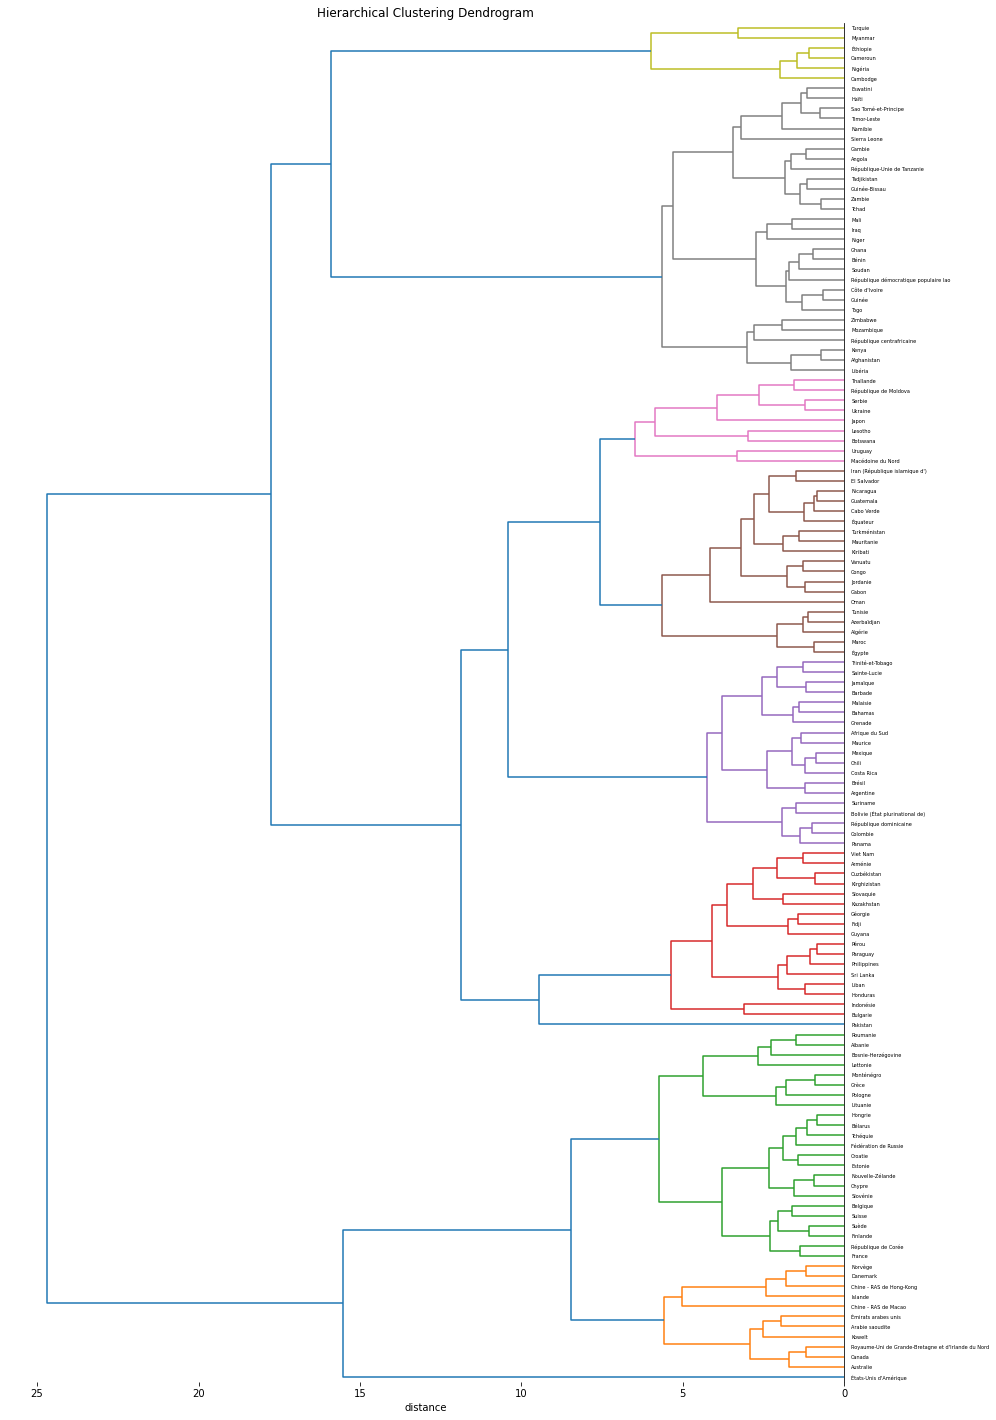

In [6]:
df_final = df_final.dropna(how = 'any')

data = df_final.set_index('Zone')
data.reset_index().head()
features = data.columns

#on replace infinitive values
data.replace({-np.inf: -1_000_000, np.inf: 1_000_000}, inplace=True)

X = data.values
names = data.index

#centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)


#clustering hiérarchique
Z = linkage(X_scaled, 'ward')

#affichage du dendrogram
plot_dendrogram(Z, names)



**Dans le dendrogramme, on peut observer 8 clusters.**

**Sur le 8 clusters, 2 concernent un seul pays et un autre concerne uniquement six pays.**

**On va faire le coupage du dendrograme en 5 clusters**

## <center>PCA</center>

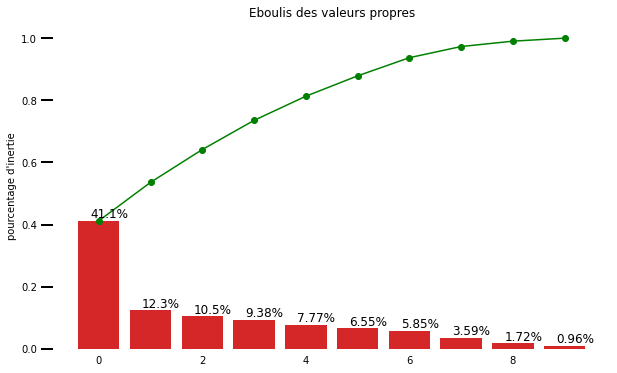

In [7]:
def pca(dataframe, n_components = None):
    
    X = data.values
    names = data.index
    features = data.columns

    #Centrage et réduction
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)
    
    pca = PCA(n_components)
    X_pca = pca.fit_transform(dataframe)
    return pca, X_pca

pca, X_pca = pca(X_scaled)

display_scree_plot(pca)

In [8]:
n_components = 8
values = pca.explained_variance_ratio_
cumulative_values = np.cumsum(values)
print("Avec {} components, {:.4f}% de la variance est expliquée".format(n_components, cumulative_values[n_components -1]*100))

Avec 8 components, 97.3079% de la variance est expliquée


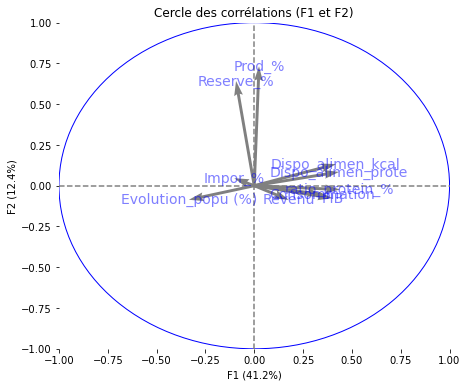

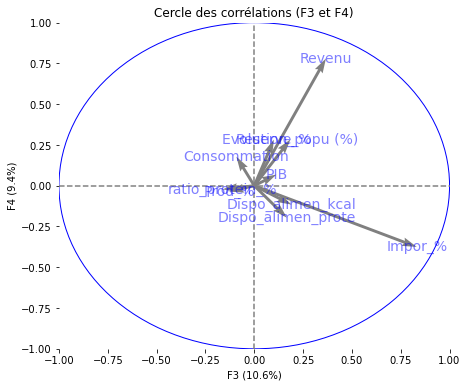

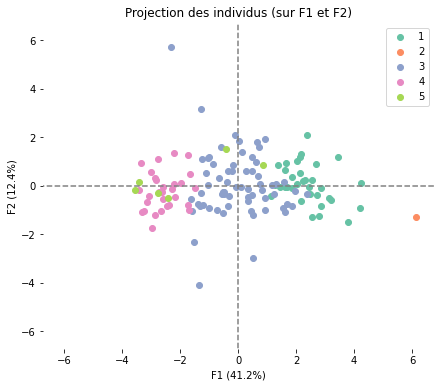

In [9]:
# choix du nombre des composantes à calculer
n_comp = 8

#préparation des données pour la PCA
#df = df.fillna(df.mean())
X = data.values
names = data.index
features = data.columns

#Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)


#n_components = 3
#pca, X_pca = pca(X_scaled, n_components=n_components)
# Calcul des composants principales
pca = decomposition.PCA(n_components = n_comp)
pca.fit(X_scaled)

#Eboulis des valeurs propres
#display_scree_plot(pca)

#Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0, 1), (2, 3)], labels = np.array(features))

#Projection des individus
#X_projected = pca.transform(X_scaled)
#display_factorial_planes(X_projected, n_comp, pca, [(0, 1), (2, 3), (4, 5)], labels = np.array(names))
plt.show()

#Coupage du dendrograme en 5 clusters
clusters = fcluster(Z, 5, criterion = 'maxclust')

#comparaison des clusters trouvés avec les classification des cours en différents thèmes
courses = pd.DataFrame({'Zone': data.index, 'clusters': clusters})
#print(courses)
courses.pivot_table(index = 'Zone', columns = 'clusters', aggfunc = len, fill_value = 0)

df_cluster = courses.sort_values(['Zone', 'clusters'])
df_cluster.head()

# On fait la jointure entre la table df et les clusters
data = pd.merge(data, df_cluster, on = 'Zone')
illustrative_var = data['clusters']
data = data.set_index('Zone')

## graphique
sns.set_palette('Set2')
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0, 1)], illustrative_var = illustrative_var)

F1 correspond au régime alimentaire, PIB.

F2 correspond aux imformations sur la (production, reserve volailles)

**Le premier axe retient 41.2% de l’inertie totale quant à l’axe 2 retient tout de même 12.4% de l’inertie, et qui conduit à un taux d’inertie expliquée de 53.6%.**

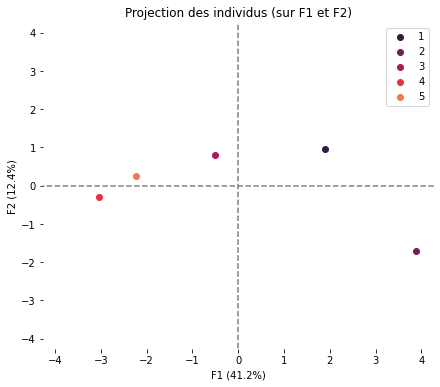

In [11]:
data2 = data.groupby('clusters').mean().reset_index()
data2 = data2.set_index('clusters')

#X = np.expand_dims(X, axis=-1)

sns.set_palette('rocket')
X = data2.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#Projection des points dans le premier plan factoriel
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0, 1)], illustrative_var = data2.index)



>### Analyse des Clusters par Boxplot

In [12]:
def boxplot_cluster(arr):
    df_bilans = data.sort_values("clusters")
    data_boxplot = []
    groupes_pays = df_bilans["clusters"].unique()
    
    for groupe in groupes_pays :
        subset = df_bilans[df_bilans.clusters == groupe]
        data_boxplot.append(subset[arr])

    fig, ax1 = plt.subplots(figsize=(12, 8))
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data_boxplot, notch=0, vert=1, whis=1.5)

    ax1.yaxis.grid(True, linestyle='-', which='major', color='green',
               alpha=0.4)
    ax1.set_axisbelow(True)
    ax1.set_title(("Distribution de " + arr +" par Cluster"), fontsize=18)
    ax1.set_ylabel(arr, fontsize = 12)
    ax1.set_xlabel("Clusters", fontsize = 12)
    ax1.set_xlim(0, len(data_boxplot) + 0.5)
    
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.show()

    plt.show()

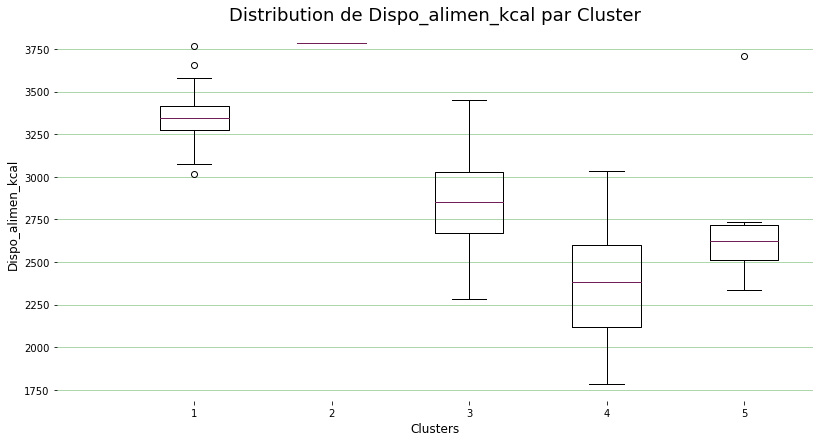

In [13]:
boxplot_cluster('Dispo_alimen_kcal')

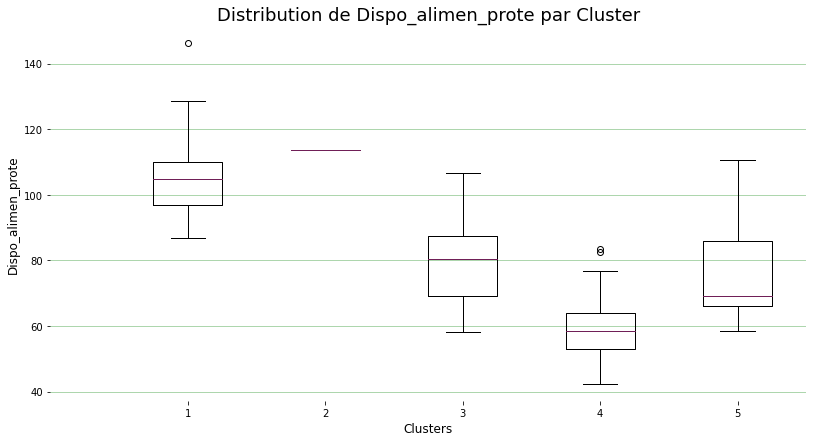

In [14]:
boxplot_cluster('Dispo_alimen_prote')

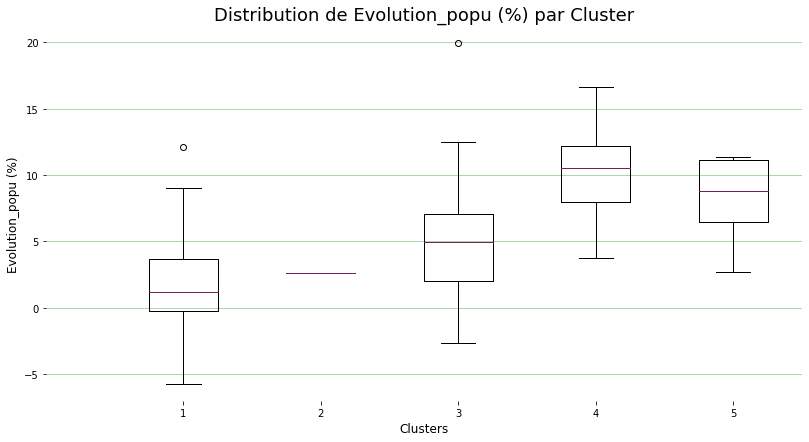

In [15]:
boxplot_cluster('Evolution_popu (%)')

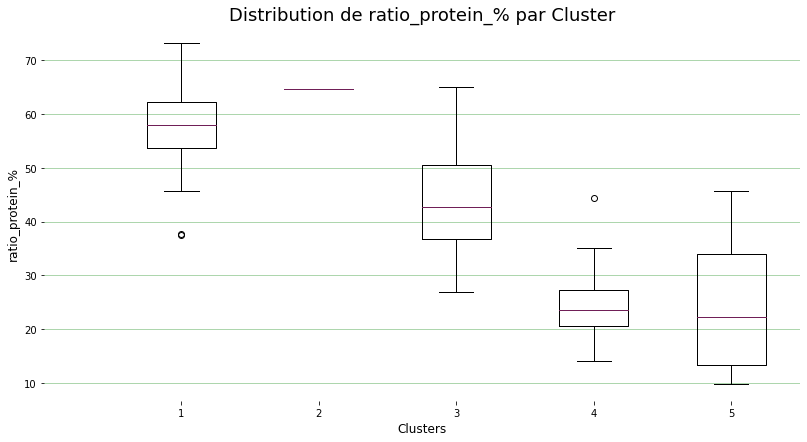

In [16]:
boxplot_cluster('ratio_protein_%')

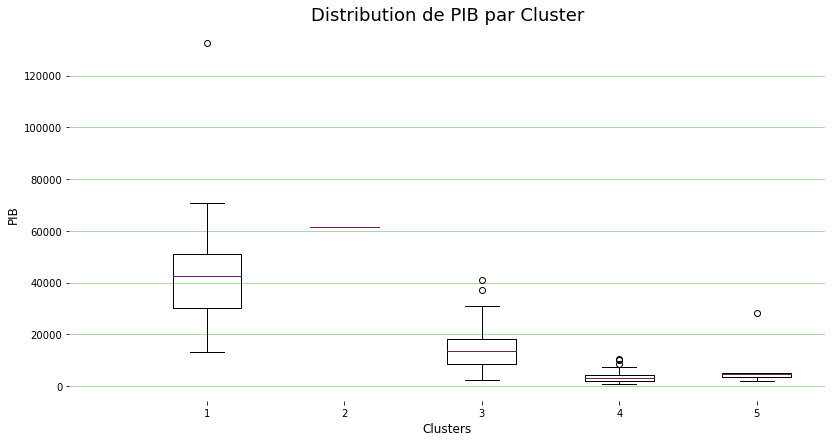

In [17]:
boxplot_cluster('PIB')

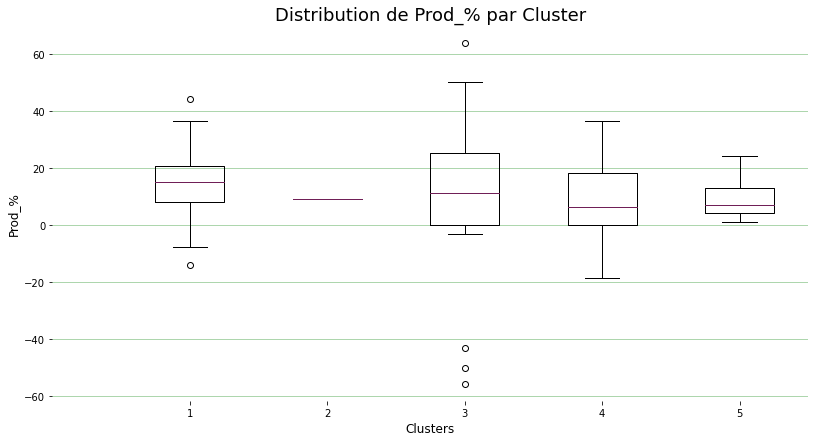

In [18]:
boxplot_cluster('Prod_%')

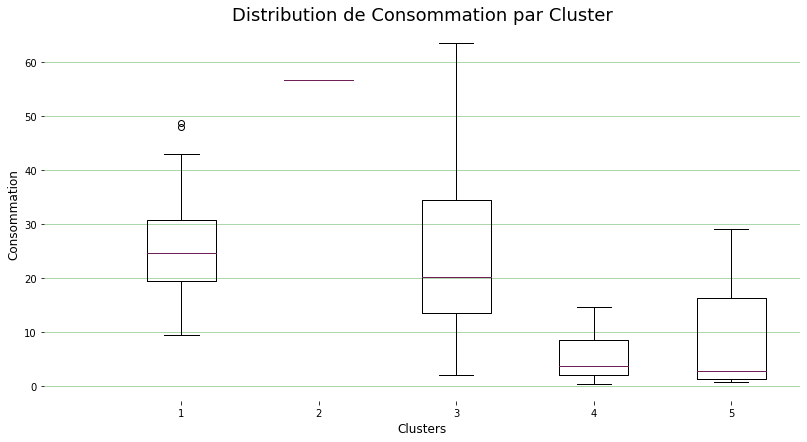

In [19]:
boxplot_cluster('Consommation')

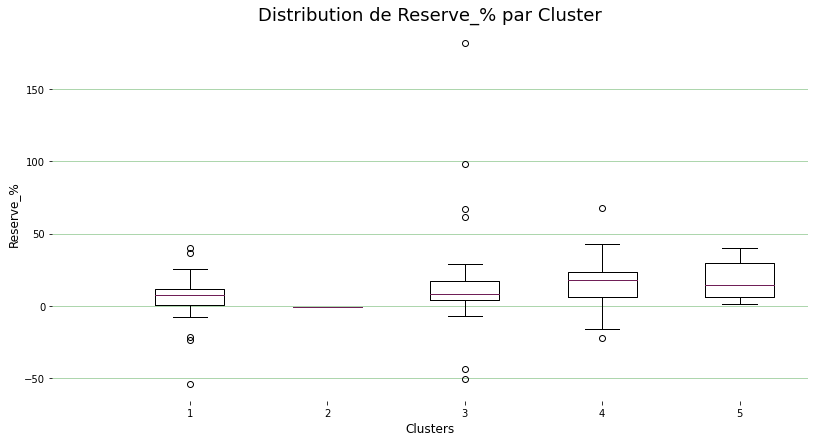

In [20]:
boxplot_cluster('Reserve_%')

### <center>Comparaison avec Kmeans<center>

In [22]:
# Over a number of different cluster counts...
k_s = np.arange(1,11)
avg_distances = []
for k in k_s:
    #print("Cluster: "+str(k))
    # run k-means clustering on the data 
    avg_dist = get_kmeans_avg_dist(X_pca, k)
    avg_distances.append(avg_dist)
    print("Cluster: {} ... Distance moyene: {:.4f}".format(k, avg_dist))

Cluster: 1 ... Distance moyene: 10.0000
Cluster: 2 ... Distance moyene: 7.0406
Cluster: 3 ... Distance moyene: 6.0977
Cluster: 4 ... Distance moyene: 5.4073
Cluster: 5 ... Distance moyene: 4.5236
Cluster: 6 ... Distance moyene: 4.0604
Cluster: 7 ... Distance moyene: 3.6713
Cluster: 8 ... Distance moyene: 3.4172
Cluster: 9 ... Distance moyene: 3.0784
Cluster: 10 ... Distance moyene: 2.9606


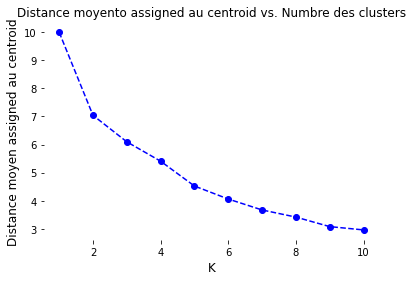

In [23]:
k_s = np.arange(1,11)
avg_distances = [10.0000, 7.0406, 6.0977, 5.4073, 4.5236,\
                 4.0604, 3.6713, 3.4172, 3.0784, 2.9606
                ]
plt.plot(k_s, avg_distances, linestyle='--', marker='o', color='b')
plt.xlabel('K', fontsize=12)
plt.ylabel('Distance moyen assigned au centroid', fontsize=12)
plt.title('Distance moyento assigned au centroid vs. Numbre des clusters', fontsize=12)

plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()

In [24]:
# silhouette score 
def get_kmeans_score(dataframe, n_clusters):
    #instantiate kmeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)

    # Then fit the model to your data using the fit method
    preds = kmeans.fit_predict(dataframe)
    #score = silhouette_score(data,preds)
    score = silhouette_score(dataframe,preds,sample_size=78,random_state=0)
    print("Cluster: {} ... Silhouette Score: {:.4f}".format(k, score))
    return score

In [25]:
k_s = np.arange(2,11)
scores = []
for k in k_s:
    # run k-means clustering 
    score = get_kmeans_score(X_pca, k)
    scores.append(score)

Cluster: 2 ... Silhouette Score: 0.3163
Cluster: 3 ... Silhouette Score: 0.3259
Cluster: 4 ... Silhouette Score: 0.1738
Cluster: 5 ... Silhouette Score: 0.1952
Cluster: 6 ... Silhouette Score: 0.1713
Cluster: 7 ... Silhouette Score: 0.1702
Cluster: 8 ... Silhouette Score: 0.1542
Cluster: 9 ... Silhouette Score: 0.1669
Cluster: 10 ... Silhouette Score: 0.1559


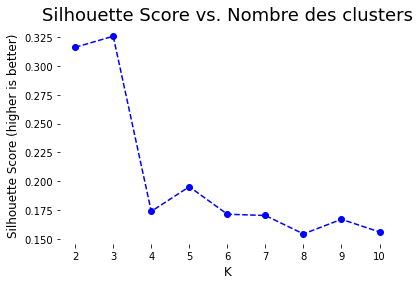

In [26]:
k_s=np.arange(2,11)
scores=[0.3163, 0.3259, 0.1738, 0.1952,\
        0.1713, 0.1702, 0.1542, 0.1669, 0.1559
       ]

plt.plot(k_s, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K', fontsize=12)
plt.ylabel('Silhouette Score (higher is better)', fontsize=12)
plt.title('Silhouette Score vs. Nombre des clusters', fontsize=18)

plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('cccc.png')
plt.show()

In [27]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
preds = kmeans.fit_predict(X_pca)

In [28]:
km_clusters = preds
#comparaison des clusters km trouvés avec les classification des cours en différents thèmes
courses_km = pd.DataFrame({'Zone': data.index, 'km_clusters': km_clusters})

courses_km.pivot_table(index = 'Zone', columns = 'km_clusters', aggfunc = len, fill_value = 0)

data_cluster_km = courses_km.sort_values(['Zone', 'km_clusters'])
data_cluster_km.head()

# On fait la jointure entre la table df et les clusters
data = pd.merge(data, data_cluster_km, on = 'Zone')
data.head(1)

,Zone,ratio_protein_%,Evolution_popu (%),Dispo_alimen_kcal,Dispo_alimen_prote,Revenu,PIB,Prod_%,Impor_%,Consommation,Reserve_%,clusters,km_clusters
0,Arménie,48.055114,1.35,2997.0,94.35,12898.194046,12715.1,33.33,3.12,15.17,7.44,3,0


>### Analyse des Kmeans Clusters par Boxplot

In [29]:
def boxplot_Km_cluster(arr):
    df_bilans = data.sort_values("km_clusters")
    data_boxplot = []
    groupes_pays = df_bilans["km_clusters"].unique()
    
    for groupe in groupes_pays :
        subset = df_bilans[df_bilans.km_clusters == groupe]
        data_boxplot.append(subset[arr])

    fig, ax1 = plt.subplots(figsize=(12, 8))
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data_boxplot, notch=0, vert=1, whis=1.5, labels=["0", "1", "2", "3", "4"])

    ax1.yaxis.grid(True, linestyle='-', which='major', color='green',
               alpha=0.4)
    ax1.set_axisbelow(True)
    ax1.set_title(("Distribution de " + arr +" par KM Cluster"), fontsize=18)
    ax1.set_ylabel(arr, fontsize = 12)
    ax1.set_xlabel("Clusters", fontsize = 12)
    ax1.set_xlim(0, len(data_boxplot) + 0.5)
    
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    #plt.savefig('dispo_alim_kcal.png')

    plt.show()

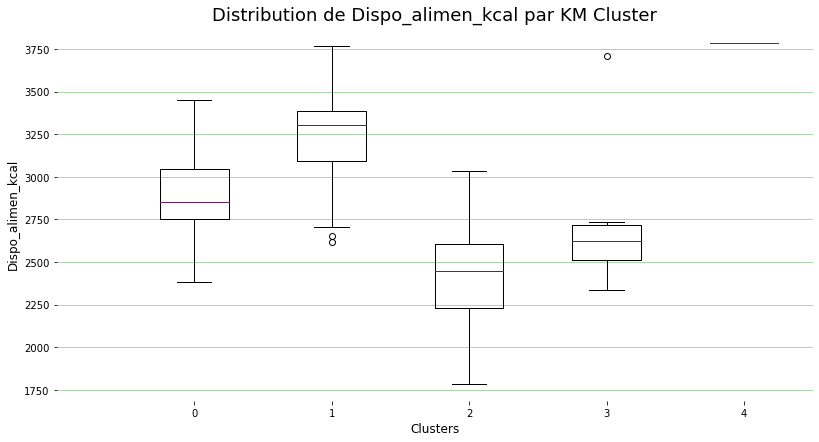

In [30]:
boxplot_Km_cluster('Dispo_alimen_kcal')

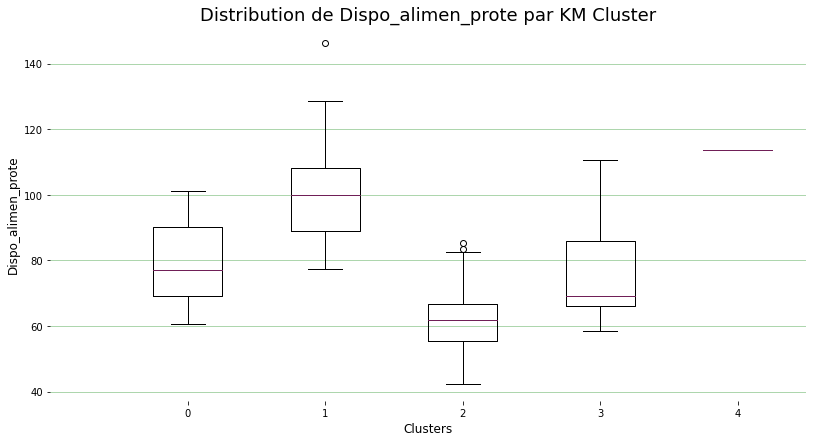

In [31]:
boxplot_Km_cluster('Dispo_alimen_prote')

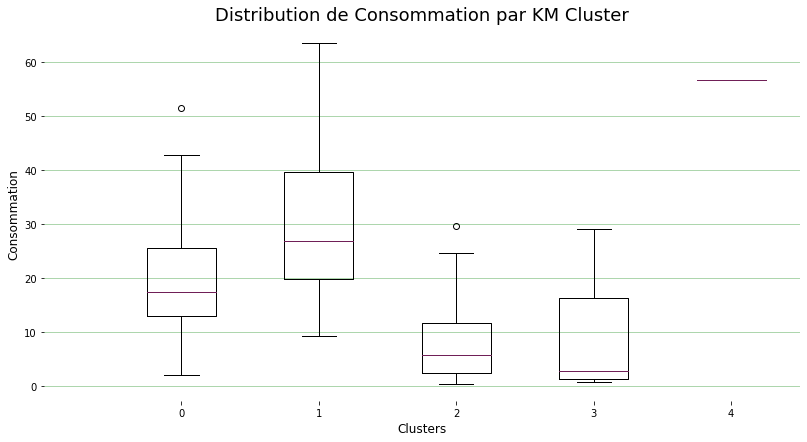

In [32]:
boxplot_Km_cluster('Consommation')

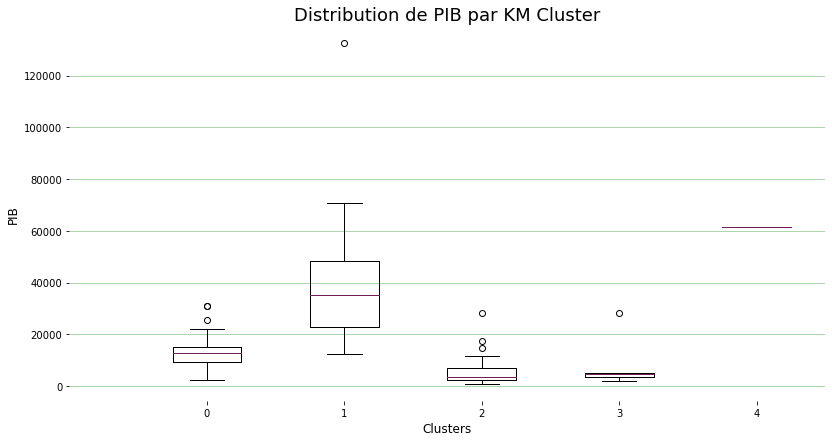

In [33]:
boxplot_Km_cluster('PIB')

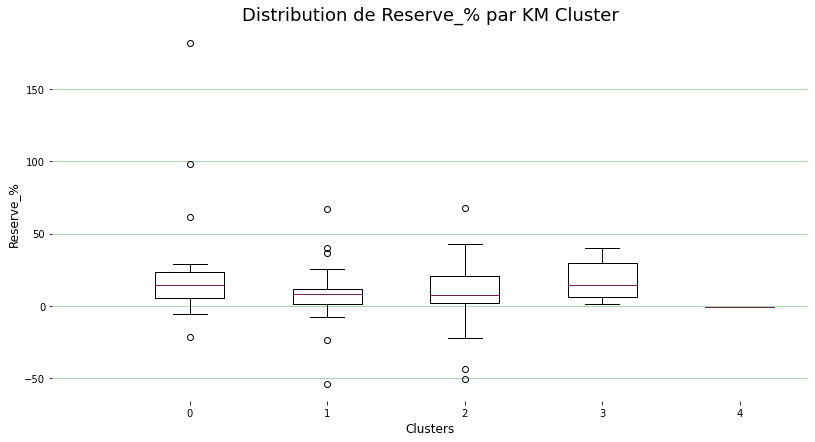

In [34]:
boxplot_Km_cluster('Reserve_%')

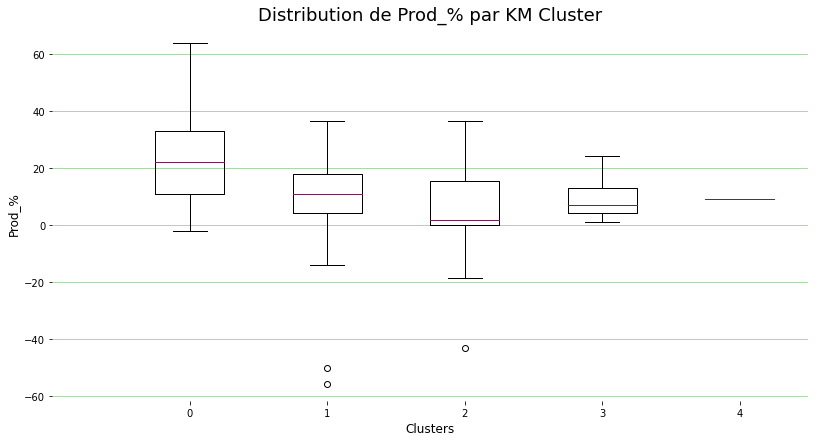

In [35]:
boxplot_Km_cluster('Prod_%')

### <center>Test d'adéquation</center>

**On va vérifier l'adéquation de nos variables à une lois normale.**

- *H$_0$ est l'hypothèse d'égalité que l'on cherche à ne pas rejeter.*
- *Le risque n'étant pas précisé, on choisira α = 5%.*

> ### Test de Kolmorogov-Smirnov et Shapiro : PIB


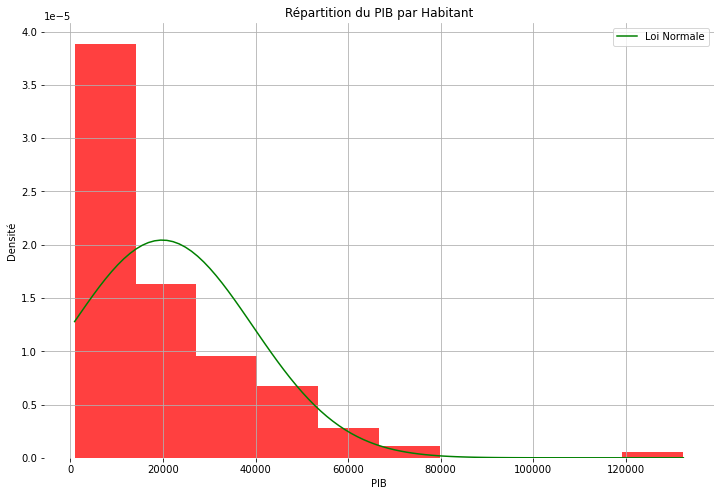

Test Kolmogorov est : KstestResult(statistic=0.18862962962962962, pvalue=0.0003510289342729678)
Test de Shapiro : ShapiroResult(statistic=0.8056557178497314, pvalue=4.30993652225653e-12)


In [36]:
#Loi normale
x_min = data['PIB'].min()
x_max = data['PIB'].max()

mean = np.mean(data['PIB'])
std = np.std(data['PIB'])

x = np.linspace(x_min, x_max, 100)
y = st.norm.pdf(x, mean, std)

#histogram
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax = ax.set(xlabel = 'PIB', ylabel = 'Densité')
plt.hist(data['PIB'], density = True, color = 'red', alpha = .75)
plt.plot(x, y, color = 'green', label = 'Loi Normale')
plt.grid(True)
plt.title('Répartition du PIB par Habitant', loc='center', fontsize=12)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

#Test de Kolmogorov Smirnov
print('Test Kolmogorov est : {}'.format(st.ks_2samp(data['PIB'], list(np.random.normal(np.mean(data['PIB'])\
                                                           , np.std(data['PIB']), 1000)))))

#Test shapiro
print('Test de Shapiro : {}'.format(st.shapiro(data['PIB'])))

*La pvalu est inférieure à 5%*, **on rejette l'hypothèse H$_0$**. *La variable PIB* **ne suit pas une loi normale.**

**Avec le test de Shapiro on obtien une pvalue inférieure à 5%. La variable PIB ne suit pas une loi normale.**

>### Test de Kolmorogov-Smirnov et Shapiro : Revenu national brut

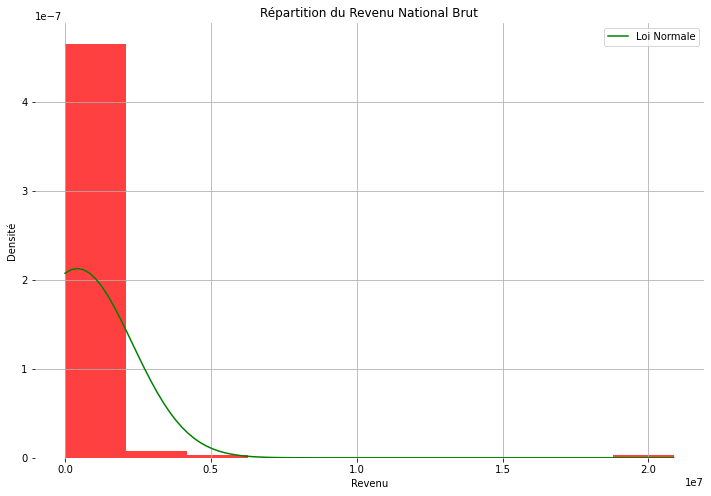

Test de Kolmogorov est : KstestResult(statistic=0.417, pvalue=4.440892098500626e-16)
Test de Shapiro est : ShapiroResult(statistic=0.1924554705619812, pvalue=5.129870958787234e-24)


In [37]:
#Loi normale
x_min = data['Revenu'].min()
x_max = data['Revenu'].max()

mean = np.mean(data['Revenu'])
std = np.std(data['Revenu'])

x = np.linspace(x_min, x_max, 100)
y = st.norm.pdf(x, mean, std)

#histogram
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax = ax.set(xlabel = 'Revenu', ylabel = 'Densité')
plt.hist(data['Revenu'], density = True, color = 'red', alpha = .75)
plt.plot(x, y, color = 'green', label = 'Loi Normale')
plt.grid(True)
plt.title('Répartition du Revenu National Brut', loc='center', fontsize=12)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.savefig('test_revenu.png')
plt.show()

#Test de Kolmogorov Smirnov
print('Test de Kolmogorov est : {}'.format(st.ks_2samp(data['Revenu'], list(np.random.normal(np.mean(data['Revenu'])\
                                                           , np.std(data['Revenu']), 1000)))))

# Test de shapiro
print('Test de Shapiro est : {}'.format(st.shapiro(data['Revenu'])))

*La pvalu est inférieure à 5%*, **on rejette l'hypothèse H$_0$**. *La variable Revenu National Brut* **ne suit pas une loi normale.**

**Avec le test de Shapiro on obtien une pvalue inférieure à 5%. La variable Revenu National Brut ne suit pas une loi normale.**

>### Test de Kolmorogov-Smirnov et Shapiro : Importations

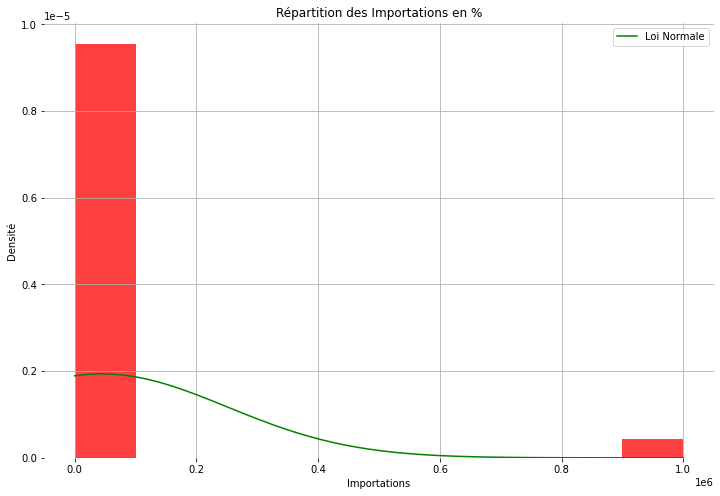

Test de Kolmogorov est : KstestResult(statistic=0.5305555555555556, pvalue=4.440892098500626e-16)
Test de Shapiro est : ShapiroResult(statistic=0.20835340023040771, pvalue=8.072668445199e-24)


In [38]:
#Loi normale
x_min = data['Impor_%'].min()
x_max = data['Impor_%'].max()

mean = np.mean(data['Impor_%'])
std = np.std(data['Impor_%'])

x = np.linspace(x_min, x_max, 100)
y = st.norm.pdf(x, mean, std)

#histogram
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax = ax.set(xlabel = 'Importations', ylabel = 'Densité')
plt.hist(data['Impor_%'], density = True, color = 'red', alpha = .75)
plt.plot(x, y, color = 'green', label = 'Loi Normale')
plt.grid(True)
plt.title('Répartition des Importations en %', loc='center', fontsize=12)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

#Test de Kolmogorov Smirnov
print('Test de Kolmogorov est : {}'.format(st.ks_2samp(data['Impor_%'], list(np.random.normal(np.mean(data['Impor_%'])\
                                                           , np.std(data['Impor_%']), 1000)))))

# Test de Shapiro
print('Test de Shapiro est : {}'.format(st.shapiro(data['Impor_%'])))

*La pvalu est inférieure à 5%*, **on rejette l'hypothèse H$_0$**. *La variable Importation* **ne suit pas une loi normale.**

*Avec le test de Shapiro on obtien une pvalue* **inférieure à 5%.** *La variable Importation* **ne suit pas une loi normale.**

>### Test de Kolmorogov-Smirnov et Shapiro: Production

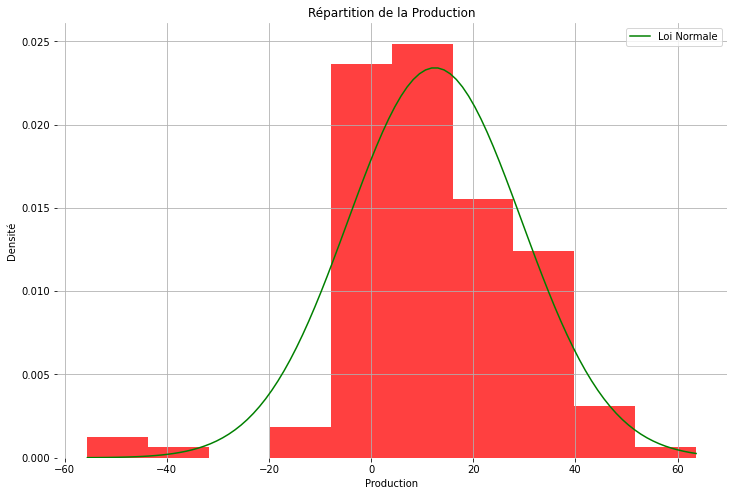

Test de Kolmogorov est : KstestResult(statistic=0.1322962962962963, pvalue=0.028037939070069573)
Test de Shapiro est : ShapiroResult(statistic=0.9344338178634644, pvalue=5.984509243717184e-06)


In [39]:
#Loi normale
x_min = data['Prod_%'].min()
x_max = data['Prod_%'].max()

mean = np.mean(data['Prod_%'])
std = np.std(data['Prod_%'])

x = np.linspace(x_min, x_max, 100)
y = st.norm.pdf(x, mean, std)

#histogram
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax = ax.set(xlabel = 'Production', ylabel = 'Densité')
plt.hist(data['Prod_%'], density = True, color = 'red', alpha = .75)
plt.plot(x, y, color = 'green', label = 'Loi Normale')
plt.grid(True)
plt.title('Répartition de la Production', loc='center', fontsize=12)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

#Test de Kolmogorov Smirnov
print('Test de Kolmogorov est : {}'.format(st.ks_2samp(data['Prod_%'], list(np.random.normal(np.mean(data['Prod_%'])\
                                                           , np.std(data['Prod_%']), 1000))))) 

# Test de Shapiro
print('Test de Shapiro est : {}'.format(st.shapiro(data['Prod_%'])))

*La pvalu est inférieure à 5%*, **on rejette l'hypothèse H$_0$**. *La variable Production* **ne suit pas une loi normale.**

*Avec le test de Shapiro on obtien une pvalue* **supérieure à 5%.** **La variable Production suit une loi normale.**

>### Test de Kolmorogov-Smirnov  et Shapiro: Reserve volailles

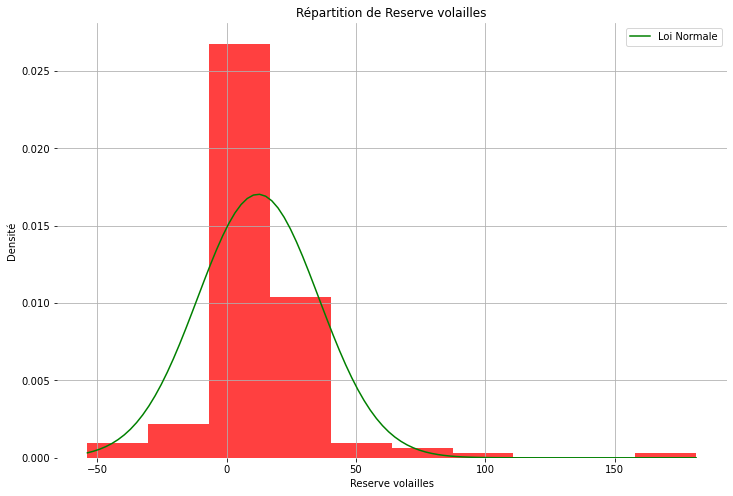

Test de Kolmogorov est : KstestResult(statistic=0.17792592592592593, pvalue=0.0009097506416825274)
Test de Shapiro est : ShapiroResult(statistic=0.7235944271087646, pvalue=1.2491315151837677e-14)


In [40]:
#Loi normale
x_min = data['Reserve_%'].min()
x_max = data['Reserve_%'].max()

mean = np.mean(data['Reserve_%'])
std = np.std(data['Reserve_%'])

x = np.linspace(x_min, x_max, 100)
y = st.norm.pdf(x, mean, std)

#histogram
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax = ax.set(xlabel = 'Reserve volailles', ylabel = 'Densité')
plt.hist(data['Reserve_%'], density = True, color = 'red', alpha = .75)
plt.plot(x, y, color = 'green', label = 'Loi Normale')
plt.grid(True)
plt.title('Répartition de Reserve volailles', loc='center', fontsize=12)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()

#Test de Kolmogorov Smirnov
print('Test de Kolmogorov est : {}'.format(st.ks_2samp(data['Reserve_%'], list(np.random.normal(np.mean(data['Reserve_%'])\
                                                           , np.std(data['Reserve_%']), 1000)))))

# Test de Shapiro
print('Test de Shapiro est : {}'.format(st.shapiro(data['Reserve_%'])))

*La pvalu est supérieure à 5%*, **on ne rejette pas l'hypothèse H$_0$**. *La variable Reserve Volailles* **ne suit pas une loi normale.**

*Avec le test de Shapiro on obtien une pvalue* **inférieure à 5%. La variable Reserve Volailles ne suit pas une loi normale.**

>### Test de Kolmorogov-Smirnov et Shapiro: Consommation volailles

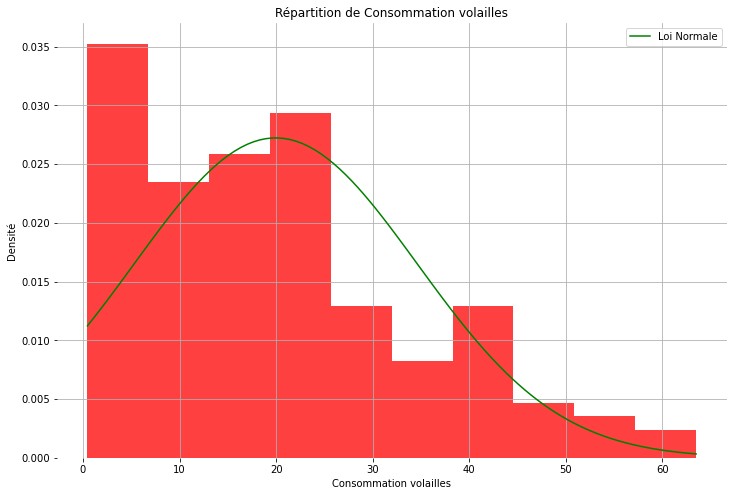

Test de Kolmogorov est : KstestResult(statistic=0.092, pvalue=0.24926361287827292)
Test de Shapiro est : ShapiroResult(statistic=0.9389474987983704, pvalue=1.235979470948223e-05)


In [41]:
#Loi normale
x_min = data['Consommation'].min()
x_max = data['Consommation'].max()

mean = np.mean(data['Consommation'])
std = np.std(data['Consommation'])

x = np.linspace(x_min, x_max, 100)
y = st.norm.pdf(x, mean, std)

#histogram
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax = ax.set(xlabel = 'Consommation volailles', ylabel = 'Densité')
plt.hist(data['Consommation'], density = True, color = 'red', alpha = .75)
plt.plot(x, y, color = 'green', label = 'Loi Normale')
plt.grid(True)
plt.title('Répartition de Consommation volailles', loc='center', fontsize=12)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.savefig('test_conso.png')
plt.show()

#Test de Kolmogorov Smirnov
print('Test de Kolmogorov est : {}'.format(st.ks_2samp(data['Consommation'], list(np.random.normal(np.mean(data['Consommation'])\
                                                           , np.std(data['Consommation']), 1000)))))

# Test de Shapiro
print('Test de Shapiro est : {}'.format(st.shapiro(data['Consommation'])))

*La pvalu est supérieure à 5%*, **on ne rejette pas l'hypothèse H$_0$**. *La variable Consommation Volailles* **suit une loi normale.**

*Avec le test de Shapiro on obtien une pvalue* **inférieure à 5%.** **La variable Consommation Volailles ne suit pas une loi normale.**


## <center>Test de comparaison</center>

**Comparaison entre les clusters 0 et 1 : disponibilité alimentaire en calories**

**Comparaison des variances: test paramétrique**

**Sous l'hypothèse nulle ($H_0$), les moyennes des clusters sont égales. L'hypothèse alternative ($H_1$) correspond à des moyennes inégales.**

>### Comparaison entre les km clusters 0 et 1 : PIB

In [42]:
# Test Fligner-Killeen (pas loi normal )
clust_0 = data[data["km_clusters"] == 0]["PIB"]
clust_1 = data[data["km_clusters"] == 1]["PIB"]
print('Test Fligner est : {}'.format(st.fligner(clust_0, clust_1)))

# Test Mann-Whitney
print('Test de Mann-Whitney est : {}'.format(st.stats.mannwhitneyu(clust_0, clust_1)))

Test Fligner est : FlignerResult(statistic=26.686960385461855, pvalue=2.3923052224845445e-07)
Test de Mann-Whitney est : MannwhitneyuResult(statistic=125.0, pvalue=2.2983610996879733e-12)


*Au seuil α = 0.05, on rejette l’hypothèse $H_0$. Les variances du* **PIB de nos 2 clusters ne sont pas égales.**

*La pvalue est inférieure à α = 0.05, nous rejetons l'hypothèse $H_0$.* **Les moyennes du PIB de nos 2 clusters ne sont pas égales.**

>### Comparaison entre les km clusters 0 et 1 : Revenu national brut

In [43]:
# Test Fligner-Killeen (pas loi normal )
# Comparaison des variances
clust_0 = data[data["km_clusters"] == 0]["Revenu"]
clust_1 = data[data["km_clusters"] == 1]["Revenu"]
print('Test Fligner est : {}'.format(st.fligner(clust_0, clust_1)))

# Test Mann-Whitney
print('Test de Mann-Whitney est : {}'.format(st.stats.mannwhitneyu(clust_0, clust_1)))

Test Fligner est : FlignerResult(statistic=18.048007500720882, pvalue=2.154039588692938e-05)
Test de Mann-Whitney est : MannwhitneyuResult(statistic=602.0, pvalue=0.0022110003730745893)


*Au seuil α = 0.05, on ne rejette pas l’hypothèse $H_0$. Les variances du* **Revenue National Brut de nos 2 clusters sont égales.**

*La pvalue est inférieure à α = 0.05, nous rejetons l'hypothèse $H_0$.* **Les moyennes du Revenue National Brut de nos 2 clusters ne sont pas égales.**

>### Comparaison entre les km clusters 0 et 1 : Importation

In [44]:
# Test Fligner-Killeen (pas loi normal )
# Comparaison des variances
clust_0 = data[data["km_clusters"] == 0]["Impor_%"]
clust_1 = data[data["km_clusters"] == 1]["Impor_%"]
print('Test Fligner est : {}'.format(st.fligner(clust_0, clust_1)))

# Test Mann-Whitney
print('Test de Mann-Whitney est : {}'.format(st.stats.mannwhitneyu(clust_0, clust_1)))

Test Fligner est : FlignerResult(statistic=3.0639372262603364, pvalue=0.08004749032931328)
Test de Mann-Whitney est : MannwhitneyuResult(statistic=719.0, pvalue=0.032201343925438504)


*Au seuil α = 0.05, on ne rejette pas l’hypothèse $H_0$. Les variances d'* **Importations de nos 2 clusters sont égales.**

*La pvalue est inférieure à α = 0.05, nous rejetons l'hypothèse $H_0$.* **Les moyennes d'Importations de nos 2 clusters ne sont pas égales.**

>### Comparaison entre les km clusters 0 et 1 : Production

In [45]:
# Test de Bartlett (suit une loi normal)
# Comparaison des variances
clust_0 = data[data["km_clusters"] == 0]["Prod_%"]
clust_1 = data[data["km_clusters"] == 1]["Prod_%"]
print('test de Barlett est : {}'.format(st.bartlett(clust_0, clust_1)))

# Test de Student
# Comparaison des moyennes
print('test de Student est : {}'.format(st.ttest_ind(clust_0, clust_1)))

test de Barlett est : BartlettResult(statistic=0.11316940705743105, pvalue=0.7365642658200433)
test de Student est : Ttest_indResult(statistic=3.8558358498153202, pvalue=0.00022353753672145772)


*Au seuil α = 0.05, on ne rejette pas l’hypothèse $H_0$. Les variances de* **Production de nos 2 clusters sont égales.**

*La pvalue est inférieure à α = 0.05, nous rejetons l'hypothèse $H_0$.* **Les moyennes de Production de nos 2 clusters ne sont pas égales.**

>### Comparaison entre les km clusters 0 et 1 : Reserve Volailles

In [46]:
# Test Fligner-Killeen (pas loi normal )
clust_0 = data[data["km_clusters"] == 0]["Reserve_%"]
clust_1 = data[data["km_clusters"] == 1]["Reserve_%"]
print('Test Fligner est : {}'.format(st.fligner(clust_0, clust_1)))

# Test Mann-Whitney
print('Test de Mann-Whitney est : {}'.format(st.stats.mannwhitneyu(clust_0, clust_1)))

Test Fligner est : FlignerResult(statistic=1.6106961447673669, pvalue=0.20439397321381694)
Test de Mann-Whitney est : MannwhitneyuResult(statistic=584.5, pvalue=0.0013688572599607205)


*Au seuil α = 0.05, on ne rejette pas l’hypothèse $H_0$. Les variances de* **Reserve Volailles de nos 2 clusters sont égales.**

*La pvalue est inférieure à α = 0.05, nous rejetons l'hypothèse $H_0$.* **Les moyennes du Reserve Volailles de nos 2 clusters ne sont pas égales.**

>### Comparaison entre les km clusters 0 et 1 : Consommation

In [47]:
# Test Fligner-Killeen (pas loi normal )
clust_0 = data[data["km_clusters"] == 0]["Consommation"]
clust_1 = data[data["km_clusters"] == 1]["Consommation"]
print('Test Fligner est : {}'.format(st.fligner(clust_0, clust_1)))

# Test Mann-Whitney
print('Test de Mann-Whitney est : {}'.format(st.stats.mannwhitneyu(clust_0, clust_1)))

Test Fligner est : FlignerResult(statistic=0.5784603549153955, pvalue=0.446916446204769)
Test de Mann-Whitney est : MannwhitneyuResult(statistic=526.0, pvalue=0.0002369946485082437)


*Au seuil α = 0.05, on ne rejette pas l’hypothèse $H_0$. Les variances de* **Consommation Volailles de nos 2 clusters sont égales.**

*La pvalue est inférieure à α = 0.05, nous rejetons l'hypothèse $H_0$.* **Les moyennes de Consommation Volailles de nos 2 clusters ne sont pas égales.**

## <center>Analyse des données des clusters 0 et 1</center>

In [48]:
# On garde que les cluster 0 et 1

pays_a_exporte = data.loc[(data['km_clusters'] == 0) | (data['km_clusters'] == 1)]
pays_a_exporte.head(1)

,Zone,ratio_protein_%,Evolution_popu (%),Dispo_alimen_kcal,Dispo_alimen_prote,Revenu,PIB,Prod_%,Impor_%,Consommation,Reserve_%,clusters,km_clusters
0,Arménie,48.055114,1.35,2997.0,94.35,12898.194046,12715.1,33.33,3.12,15.17,7.44,3,0


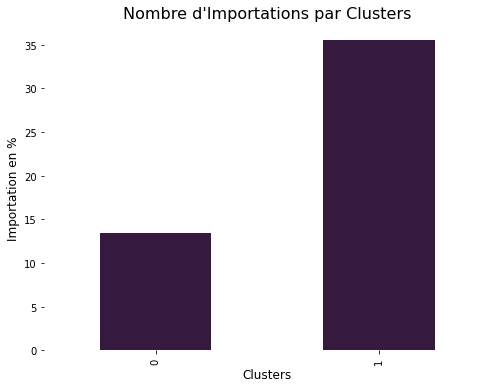

In [49]:
# plotting a bar graph of importation
plt.figure(figsize=(8, 6))
impor = pays_a_exporte.groupby('km_clusters')['Impor_%'].mean()
impor.plot(kind='bar')
plt.title('Nombre d\'Importations par Clusters', fontsize=16)
plt.xlabel('Clusters', fontsize=12)
plt.ylabel('Importation en %', fontsize=12)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
#plt.savefig('import.png')
plt.show()

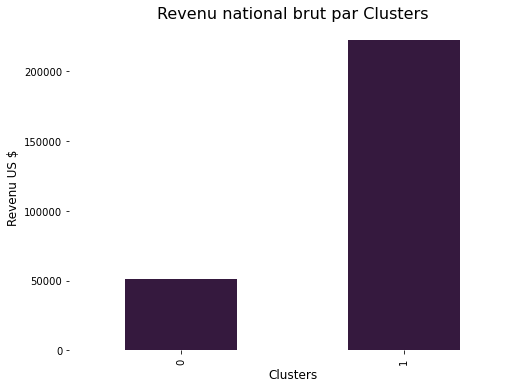

In [50]:
# plotting a bar graph of Revenu
plt.figure(figsize=(8, 6))
reve = pays_a_exporte.groupby('km_clusters')['Revenu'].median()
reve.plot(kind='bar')
plt.title('Revenu national brut par Clusters', fontsize=16)
plt.xlabel('Clusters', fontsize=12)
plt.ylabel('Revenu US $', fontsize=12)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
#plt.savefig('revenu.png')
plt.show()

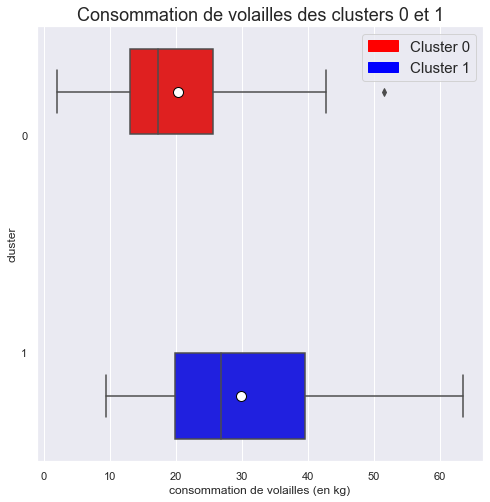

In [51]:
sns.set(rc={'figure.figsize':(8,8)})
my_pal = ["red", "blue"]


plt.title("Consommation de volailles des clusters 0 et 1", size=18)

boxplot_prix = sns.boxplot(x="Consommation",y="km_clusters", 
                           data=pays_a_exporte, 
                           hue="km_clusters", showmeans=True, 
                           meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"}, palette=my_pal, orient="h")
boxplot_prix.set(xlabel="consommation de volailles (en kg)",ylabel="cluster")

cluster0 = mpatches.Patch(color="red", label="Cluster 0")
cluster4 = mpatches.Patch(color="blue", label="Cluster 1")


boxplot_prix.legend(handles=[cluster0,cluster4], prop={"size":15})
plt.savefig('conso_box.png')
plt.show()


>### Chois Final :

**Le cluster 1 est le plus intéressant pour se développer :**
- Une consommation des volailles plus élevée, Revenu national Brut plus important et une dependance au importation à la viande des volailles un peu plus important.
- L'Australie, Le Canada, la Finlande et la Chine semblent être les plays les plus intéressants compte tenu de leur aliméntation protéiné, revenu et PIB plus élevé